# Projection Layer v2: Hard Negatives + Margin Loss

This notebook refactors the original `CS229_ProjectionLayer.ipynb` into a reusable training flow with:

- the same dual-MLP projection idea (poem branch, song branch, shared 128-d space),
- mined hard negatives + triplet margin loss alongside InfoNCE/CLIP loss,
- optional human-provided positives/negatives to override noisy pseudo-pairs.

**Relation to the original notebook**

- Keeps the input prep: MPNet embeddings + engineered structural/semantic/lexical features (`full_features.npz`) concatenated per side.
- Keeps percentile-based pseudo-positives/negatives from raw MPNet cosine, but now uses them for both positives and hard/easy negatives.
- Fixes the unused `s_neg` issue by explicitly training with hard negatives and a margin term.
- Adds a hook for human labels so you can inject judged pairs without rewriting code.
- Exposes small hyperparameters at the top for quick sweeps.

To supply human matches, create a JSONL at `data/processed/human_labels.jsonl` (schema described in the human-labels cell).

In [ ]:
import json
import os
from pathlib import Path
from typing import Iterable, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Ffu
from torch.utils.data import DataLoader, Dataset

PROJECT_ROOT = Path.cwd()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Max out CPU threads for PyTorch on this machine
torch.set_num_threads(os.cpu_count())

# Quick knobs
EPOCHS = 20
BATCH_SIZE = 256
SAMPLES_PER_EPOCH = 20000
LR = 1e-3
PROJ_DIM = 128
TEMPERATURE = 0.05
MARGIN = 0.2
CONTRAST_W = 1.0
TRIPLET_W = 1.0
ALIGN_W = 0.5
POS_PCT = 95.0
NEG_PCT = 20.0
HARD_LOW = 40.0
HARD_HIGH = 70.0
NUM_WORKERS = min(8, os.cpu_count() or 1)
PIN_MEMORY = torch.cuda.is_available()


In [17]:
def load_embeddings():
    poem_vecs = np.load(PROJECT_ROOT / "data/processed/mpnet_embeddings_poems.npy")
    song_vecs = np.load(PROJECT_ROOT / "data/processed/mpnet_embeddings_songs.npy")
    feats = np.load(PROJECT_ROOT / "data/processed/full_features.npz")

    poem_feats = np.concatenate(
        [feats["poem_struct"], feats["poem_semantic"], feats["poem_lexical"]],
        axis=1,
    )
    song_feats = np.concatenate(
        [feats["song_struct"], feats["song_semantic"], feats["song_lexical"]],
        axis=1,
    )

    def _standardize(x):
        mean = x.mean(axis=0, keepdims=True)
        std = x.std(axis=0, keepdims=True) + 1e-6
        return (x - mean) / std

    poem_feats_std = _standardize(poem_feats)
    song_feats_std = _standardize(song_feats)

    song_source_indexes = feats["song_source_indexes"]
    song_vecs = song_vecs[song_source_indexes]
    song_feats_std = song_feats_std[song_source_indexes]

    poem_in = np.concatenate([poem_vecs, poem_feats_std], axis=1)
    song_in = np.concatenate([song_vecs, song_feats_std], axis=1)
    return poem_in, song_in, poem_vecs, song_vecs, song_source_indexes


poem_in, song_in, poem_vecs, song_vecs, song_source_indexes = load_embeddings()
poem_in.shape, song_in.shape


((3413, 771), (2934, 772))

In [18]:
def compute_seed_pairs(poem_vecs, song_vecs):
    poems_norm = poem_vecs / np.linalg.norm(poem_vecs, axis=1, keepdims=True)
    songs_norm = song_vecs / np.linalg.norm(song_vecs, axis=1, keepdims=True)
    cos_matrix = poems_norm @ songs_norm.T
    cos_vals = cos_matrix.ravel()

    neg_thresh = np.percentile(cos_vals, NEG_PCT)
    hard_low = np.percentile(cos_vals, HARD_LOW)
    hard_high = np.percentile(cos_vals, HARD_HIGH)
    pos_thresh = np.percentile(cos_vals, POS_PCT)

    pos_pairs = np.argwhere(cos_matrix >= pos_thresh)
    neg_pairs = np.argwhere(cos_matrix <= neg_thresh)
    hard_pairs = np.argwhere((cos_matrix >= hard_low) & (cos_matrix <= hard_high))
    return cos_matrix, pos_pairs, neg_pairs, hard_pairs


cos_matrix, pos_pairs, neg_pairs, hard_pairs = compute_seed_pairs(poem_vecs, song_vecs)
len(pos_pairs), len(neg_pairs), len(hard_pairs)

(1001375, 2002749, 3004122)

### Optional: load human labels

Create `data/processed/human_labels.jsonl` with lines like:

- `{"poem_index": 42, "song_index_aligned": 17, "label": 1}`
- `{"poem_index": 42, "song_index_raw": 1234, "label": 0}` (raw index in combined_songs_large_fixed.json)
- `{"poem_index": 42, "song_title": "Opalite", "song_artist": "Taylor Swift", "label": 1}`

Label 1 = positive, 0 = negative. If the file is absent, training just uses pseudo-labels.

In [19]:
def load_human_labels(path: Path, song_source_indexes: np.ndarray, raw_songs: list[dict]):
    positives: list[Tuple[int, int]] = []
    negatives: list[Tuple[int, int]] = []
    if not path.exists():
        return positives, negatives

    raw_to_aligned = {int(raw_idx): i for i, raw_idx in enumerate(song_source_indexes)}
    title_artist_to_raw = {}
    for idx, song in enumerate(raw_songs):
        key = (song.get("title", "").lower().strip(), song.get("artist", "").lower().strip())
        title_artist_to_raw[key] = idx

    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            entry = json.loads(line)
            poem_idx = int(entry["poem_index"])
            aligned_idx = None

            if "song_index_aligned" in entry:
                aligned_idx = int(entry["song_index_aligned"])
            elif "song_index_raw" in entry:
                raw_idx = int(entry["song_index_raw"])
                aligned_idx = raw_to_aligned.get(raw_idx)
            elif "song_title" in entry and "song_artist" in entry:
                key = (entry["song_title"].lower().strip(), entry["song_artist"].lower().strip())
                raw_idx = title_artist_to_raw.get(key)
                if raw_idx is not None:
                    aligned_idx = raw_to_aligned.get(raw_idx)

            if aligned_idx is None:
                continue
            label = int(entry.get("label", 1))
            if label == 1:
                positives.append((poem_idx, aligned_idx))
            else:
                negatives.append((poem_idx, aligned_idx))
    return positives, negatives


with (PROJECT_ROOT / "data/processed/combined_songs_large_fixed.json").open("r", encoding="utf-8") as f:
    raw_songs = json.load(f)["items"]

human_labels_path = PROJECT_ROOT / "data/processed/human_labels.jsonl"
human_pos, human_neg = load_human_labels(human_labels_path, song_source_indexes, raw_songs)
len(human_pos), len(human_neg)

(500, 0)

In [20]:
class PairDataset(Dataset):
    def __init__(self, poem_in, song_in, pos_pairs, neg_pairs, hard_pairs, human_pos, human_neg, size=50000):
        self.poem_in = poem_in
        self.song_in = song_in
        self.pos_pairs = np.concatenate([pos_pairs, np.array(human_pos, dtype=np.int64)], axis=0) if human_pos else pos_pairs
        self.neg_pairs = np.concatenate([neg_pairs, np.array(human_neg, dtype=np.int64)], axis=0) if human_neg else neg_pairs
        self.hard_pairs = hard_pairs
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        i, j_pos = self.pos_pairs[np.random.randint(len(self.pos_pairs))]
        if len(self.hard_pairs) > 0 and np.random.rand() < 0.5:
            i_neg, j_neg = self.hard_pairs[np.random.randint(len(self.hard_pairs))]
        else:
            i_neg, j_neg = self.neg_pairs[np.random.randint(len(self.neg_pairs))]

        p = torch.tensor(self.poem_in[i], dtype=torch.float32)
        s_pos = torch.tensor(self.song_in[j_pos], dtype=torch.float32)
        s_neg = torch.tensor(self.song_in[j_neg], dtype=torch.float32)
        return p, s_pos, s_neg


dataset = PairDataset(poem_in, song_in, pos_pairs, neg_pairs, hard_pairs, human_pos, human_neg, size=SAMPLES_PER_EPOCH)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
len(loader)


157

In [32]:
class ProjectionModel(nn.Module):
    def __init__(self, p_dim, s_dim, proj_dim=128):
        super().__init__()
        self.poem_proj = nn.Sequential(
            nn.Linear(p_dim, 256),
            nn.ReLU(),
            nn.Linear(256, proj_dim),
        )
        self.song_proj = nn.Sequential(
            nn.Linear(s_dim, 256),
            nn.ReLU(),
            nn.Linear(256, proj_dim),
        )

    def forward(self, p, s):
        p_z = self.poem_proj(p)
        s_z = self.song_proj(s)
        p_norm = F.normalize(p_z, dim=1)
        s_norm = F.normalize(s_z, dim=1)
        return (p_norm * s_norm).sum(dim=1)


def clip_loss(p_z, s_z, temperature):
    p = F.normalize(p_z, dim=1)
    s = F.normalize(s_z, dim=1)
    logits = (p @ s.T) / temperature
    labels = torch.arange(logits.shape[0], device=logits.device)
    return 0.5 * (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels))


def triplet_margin(p_z, s_pos_z, s_neg_z, margin):
    p = F.normalize(p_z, dim=1)
    s_pos = F.normalize(s_pos_z, dim=1)
    s_neg = F.normalize(s_neg_z, dim=1)
    pos_sim = (p * s_pos).sum(dim=1)
    neg_sim = (p * s_neg).sum(dim=1)
    return F.relu(pos_sim - neg_sim + margin).mean()


model = ProjectionModel(poem_in.shape[1], song_in.shape[1], PROJ_DIM).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
loss_history = []
model.train()
for epoch in range(1, EPOCHS + 1):
    total = 0.0
    for p, s_pos, s_neg in loader:
        p = p.to(DEVICE)
        s_pos = s_pos.to(DEVICE)
        s_neg = s_neg.to(DEVICE)

        p_z = model.poem_proj(p)
        s_pos_z = model.song_proj(s_pos)
        s_neg_z = model.song_proj(s_neg)

        loss_clip = clip_loss(p_z, s_pos_z, TEMPERATURE)
        loss_trip = triplet_margin(p_z, s_pos_z, s_neg_z, MARGIN)
        loss_align = F.mse_loss(p_z, s_pos_z)

        loss = CONTRAST_W * loss_clip + TRIPLET_W * loss_trip + ALIGN_W * loss_align
        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()
    avg = total / len(loader)
    loss_history.append(avg)
    print(f"epoch {epoch}/{EPOCHS} loss={avg:.4f}")

torch.save({"state_dict": model.state_dict(), "proj_dim": PROJ_DIM, "temperature": TEMPERATURE}, PROJECT_ROOT / "models/projection_hardneg.pt")
print("Saved to", PROJECT_ROOT / "models/projection_hardneg.pt")

In [33]:
# Load trained projection and set up recommender
ckpt_path = PROJECT_ROOT / 'models' / 'projection_hardneg.pt'
if not ckpt_path.exists():
    raise FileNotFoundError(f'Missing checkpoint at {ckpt_path}')

ckpt = torch.load(ckpt_path, map_location='cpu')
proj_dim = ckpt.get('proj_dim', PROJ_DIM) if isinstance(ckpt, dict) else PROJ_DIM
model = ProjectionModel(poem_in.shape[1], song_in.shape[1], proj_dim)
# Handle checkpoints saved as {'model_state': ...} or direct state_dict
state_dict = None
if isinstance(ckpt, dict):
    state_dict = ckpt.get('model_state') or ckpt.get('state_dict')
if state_dict is None:
    state_dict = ckpt
model.load_state_dict(state_dict)
model.eval()

# Precompute normalized embeddings for fast retrieval
with torch.no_grad():
    poems_z = model.poem_proj(torch.tensor(poem_in, dtype=torch.float32))
    songs_z = model.song_proj(torch.tensor(song_in, dtype=torch.float32))
    poems_z = F.normalize(poems_z, dim=1).cpu().numpy()
    songs_z = F.normalize(songs_z, dim=1).cpu().numpy()

raw_songs = json.load((PROJECT_ROOT / 'data/processed/combined_songs_large_fixed.json').open())['items']
aligned_to_raw = {i: int(raw_idx) for i, raw_idx in enumerate(song_source_indexes)}
poem_titles = [p.get('title', 'Untitled Poem') for p in json.load((PROJECT_ROOT / 'data/raw/poetrydb_poems.json').open())['items']]

def recommend_for_poem(poem_idx: int, top_k: int = 5):
    scores = poems_z[poem_idx] @ songs_z.T
    top_idx = scores.argsort()[-top_k:][::-1]
    recs = []
    for idx in top_idx:
        raw_idx = aligned_to_raw[idx]
        song = raw_songs[raw_idx]
        recs.append({
            'score': float(scores[idx]),
            'song_title': song.get('title', ''),
            'song_artist': song.get('artist', ''),
            'aligned_index': int(idx),
            'raw_index': int(raw_idx),
        })
    return recs

example_idx = 0
print(f'Example poem {example_idx}: {poem_titles[example_idx]}')
for r in recommend_for_poem(example_idx, top_k=5):
    print('{:.3f}  {} — {}'.format(r['score'], r['song_title'], r['song_artist']))


Example poem 0: A Song of Autumn
0.644  JB2 RADIO — Travis Scott
0.611  Intro - Stop In Nevada — Billy Joel
0.608  The Getting By — The Killers
0.602  Keep Driving — Harry Styles
0.592  West Hills — The Killers


Recall@5: 0.048 over 63 poems with labels
Recall@10: 0.111 over 63 poems with labels


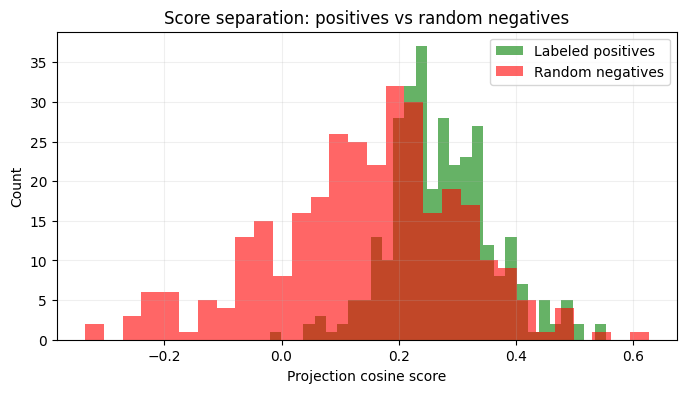

In [34]:
import matplotlib.pyplot as plt
from collections import defaultdict

labels_path = PROJECT_ROOT / 'data/processed/human_labels.jsonl'
human_pos = defaultdict(list)
if labels_path.exists():
    with labels_path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            entry = json.loads(line)
            if int(entry.get('label', 1)) != 1:
                continue
            human_pos[int(entry['poem_index'])].append(int(entry['song_index_aligned']))

def recall_at_k(k=5):
    if not human_pos:
        return 0.0, 0
    hits = 0
    total = len(human_pos)
    for p_idx, pos_songs in human_pos.items():
        scores = poems_z[p_idx] @ songs_z.T
        top_idx = set(scores.argsort()[-k:])
        if any(s in top_idx for s in pos_songs):
            hits += 1
    return hits / total, total

r5, n_pairs = recall_at_k(5)
r10, _ = recall_at_k(10)
print(f'Recall@5: {r5:.3f} over {n_pairs} poems with labels')
print(f'Recall@10: {r10:.3f} over {n_pairs} poems with labels')

pos_scores = []
neg_scores = []
rng = np.random.default_rng(0)
for p_idx, pos_songs in human_pos.items():
    scores = poems_z[p_idx] @ songs_z.T
    for s_idx in pos_songs:
        pos_scores.append(scores[s_idx])
        neg_candidate = rng.choice(scores.shape[0])
        while neg_candidate in pos_songs:
            neg_candidate = rng.choice(scores.shape[0])
        neg_scores.append(scores[neg_candidate])

plt.figure(figsize=(8,4))
plt.hist(pos_scores, bins=30, alpha=0.6, label='Labeled positives', color='green')
plt.hist(neg_scores, bins=30, alpha=0.6, label='Random negatives', color='red')
plt.xlabel('Projection cosine score')
plt.ylabel('Count')
plt.title('Score separation: positives vs random negatives')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [35]:
# Optional: quick grid search over hyperparameters (CPU-friendly)
import time

def _recall_at_k_grid(poems_z, songs_z, human_pos_dict, k=5):
    if not human_pos_dict:
        return 0.0
    hits = 0
    for p_idx, pos_songs in human_pos_dict.items():
        scores = poems_z[p_idx] @ songs_z.T
        top_idx = set(scores.argsort()[-k:])
        if any(s in top_idx for s in pos_songs):
            hits += 1
    return hits / len(human_pos_dict)

def _compute_pairs_custom(poem_vecs, song_vecs, pos_pct, neg_pct, hard_low_pct, hard_high_pct):
    poems_norm = poem_vecs / np.linalg.norm(poem_vecs, axis=1, keepdims=True)
    songs_norm = song_vecs / np.linalg.norm(song_vecs, axis=1, keepdims=True)
    cos_matrix = poems_norm @ songs_norm.T
    cos_vals = cos_matrix.ravel()
    neg_thresh = np.percentile(cos_vals, neg_pct)
    hard_low = np.percentile(cos_vals, hard_low_pct)
    hard_high = np.percentile(cos_vals, hard_high_pct)
    pos_thresh = np.percentile(cos_vals, pos_pct)
    pos_pairs = np.argwhere(cos_matrix >= pos_thresh)
    neg_pairs = np.argwhere(cos_matrix <= neg_thresh)
    hard_pairs = np.argwhere((cos_matrix >= hard_low) & (cos_matrix <= hard_high))
    return cos_matrix, pos_pairs, neg_pairs, hard_pairs

def run_grid_search():
    temps = [0.05, 0.1, 0.2]
    margins = [0.2, 0.4]
    pos_pcts = [90.0, 95.0]
    neg_pcts = [10.0, 20.0]
    base_epochs = 3
    samples_per_epoch = 5000
    batch_size = 256

    human_pos_dict = {}
    if 'human_pos' in globals():
        human_pos_dict = {k: list(v) for k, v in human_pos.items()}

    results = []
    start_all = time.time()

    for temp in temps:
        for margin in margins:
            for pos_pct in pos_pcts:
                for neg_pct in neg_pcts:
                    cos_matrix, pos_pairs, neg_pairs, hard_pairs = _compute_pairs_custom(
                        poem_vecs, song_vecs, pos_pct, neg_pct, HARD_LOW, HARD_HIGH
                    )

                    dataset = PairDataset(
                        poem_in, song_in, pos_pairs, neg_pairs, hard_pairs,
                        human_pos=[(p, s) for p, lst in human_pos_dict.items() for s in lst],
                        human_neg=[],
                        size=samples_per_epoch,
                    )
                    loader = DataLoader(
                        dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False
                    )

                    model = ProjectionModel(poem_in.shape[1], song_in.shape[1], PROJ_DIM).to(DEVICE)
                    opt = torch.optim.Adam(model.parameters(), lr=LR)

                    for _ in range(base_epochs):
                        model.train()
                        for p, s_pos, s_neg in loader:
                            p = p.to(DEVICE)
                            s_pos = s_pos.to(DEVICE)
                            s_neg = s_neg.to(DEVICE)
                            p_z = model.poem_proj(p)
                            s_pos_z = model.song_proj(s_pos)
                            s_neg_z = model.song_proj(s_neg)
                            loss_clip = clip_loss(p_z, s_pos_z, temperature=temp)
                            loss_trip = triplet_margin(p_z, s_pos_z, s_neg_z, margin=margin)
                            loss_align = F.mse_loss(p_z, s_pos_z)
                            loss = CONTRAST_W * loss_clip + TRIPLET_W * loss_trip + ALIGN_W * loss_align
                            opt.zero_grad()
                            loss.backward()
                            opt.step()

                    with torch.no_grad():
                        poems_z = model.poem_proj(torch.tensor(poem_in, dtype=torch.float32, device=DEVICE))
                        songs_z = model.song_proj(torch.tensor(song_in, dtype=torch.float32, device=DEVICE))
                        poems_z = F.normalize(poems_z, dim=1).cpu().numpy()
                        songs_z = F.normalize(songs_z, dim=1).cpu().numpy()
                    r5 = _recall_at_k_grid(poems_z, songs_z, human_pos_dict, k=5)
                    r10 = _recall_at_k_grid(poems_z, songs_z, human_pos_dict, k=10)
                    results.append({
                        'temp': temp, 'margin': margin, 'pos_pct': pos_pct, 'neg_pct': neg_pct,
                        'recall@5': r5, 'recall@10': r10
                    })
                    print('temp={} margin={} pos={} neg={} -> R@5={:.3f} R@10={:.3f}'.format(temp, margin, pos_pct, neg_pct, r5, r10))

    elapsed = time.time() - start_all
    print('Grid search complete in {:.2f} min, {} runs'.format(elapsed/60, len(results)))
    return results

grid_results = run_grid_search()
grid_results[:3]


temp=0.05 margin=0.2 pos=90.0 neg=10.0 -> R@5=0.286 R@10=0.460
temp=0.05 margin=0.2 pos=90.0 neg=20.0 -> R@5=0.032 R@10=0.079
temp=0.05 margin=0.2 pos=95.0 neg=10.0 -> R@5=0.143 R@10=0.222


KeyboardInterrupt: 

In [36]:
# Compute AUC / PR-AUC on labeled pairs (sanity check)
from sklearn.metrics import roc_auc_score, average_precision_score

auc = None
ap = None
if human_pos:
    y_true = []
    y_score = []
    for p_idx, pos_songs in human_pos.items():
        scores = poems_z[p_idx] @ songs_z.T
        for s_idx in pos_songs:
            y_true.append(1)
            y_score.append(scores[s_idx])
        # sample one negative per positive for balance
        for s_idx in pos_songs:
            # pick a random other song
            neg = 0
            while neg in pos_songs:
                neg = np.random.randint(scores.shape[0])
            y_true.append(0)
            y_score.append(scores[neg])
    try:
        auc = roc_auc_score(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
    except Exception as e:
        print('AUC computation failed:', e)

print(f'AUC: {auc:.3f}' if auc is not None else 'AUC: N/A')
print(f'PR-AUC: {ap:.3f}' if ap is not None else 'PR-AUC: N/A')


AUC: 0.693
PR-AUC: 0.737
